## Importing dependencies

In [2]:
import gym
import gym_anytrading
from gym_anytrading.envs import StocksEnv
from gym_anytrading.datasets import STOCKS_GOOGL
import itertools
import warnings
import statsmodels.api as sm
import datetime
from statsmodels.tsa.arima_model import ARIMA

## RL dependencies

In [3]:
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import A2C


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/home/dippy/Studies/dl_diploma/venv/lib/python3.7/site-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


## Processing dependencies

In [4]:
import numpy as np
import pandas as pnd
from matplotlib import pyplot as plt

In [19]:
df = pnd.read_csv('datasets/AAPL.csv')
df.head()

,date,volume,open,close,high,low,adjclose
0,2018-11-02,91263400,209.550003,207.479996,213.649994,205.429993,207.479996
1,2018-11-01,58323200,219.050003,222.220001,222.360001,216.809998,222.220001
2,2018-10-31,38358900,216.880005,218.860001,220.449997,216.619995,218.860001
3,2018-10-30,36660000,211.149994,213.300003,215.179993,209.270004,213.300003
4,2018-10-29,45935500,219.190002,212.240005,219.690002,206.089996,212.240005


In [20]:
df['date'] = pnd.to_datetime(df['date'], format='%Y-%m-%d')
df.dtypes

date        datetime64[ns]
volume               int64
open               float64
close              float64
high               float64
low                float64
adjclose           float64
dtype: object

In [21]:
df.isnull().sum()

date        0
volume      0
open        0
close       0
high        0
low         0
adjclose    0
dtype: int64

In [22]:
df.sort_values('date', ascending=True, inplace=True)
df.head()

,date,volume,open,close,high,low,adjclose
9555,1980-12-12,117258400,0.513393,0.513393,0.515625,0.513393,0.023186
9554,1980-12-15,43971200,0.488839,0.486607,0.488839,0.486607,0.021977
9553,1980-12-16,26432000,0.453125,0.450893,0.453125,0.450893,0.020364
9552,1980-12-17,21610400,0.462054,0.462054,0.464286,0.462054,0.020868
9551,1980-12-18,18362400,0.475446,0.475446,0.477679,0.475446,0.021473


In [23]:
df.date.dt.to_period('M')

9555    1980-12
9554    1980-12
9553    1980-12
9552    1980-12
9551    1980-12
         ...   
4       2018-10
3       2018-10
2       2018-10
1       2018-11
0       2018-11
Name: date, Length: 9556, dtype: period[M]

In [24]:
df.drop(columns=['adjclose'], inplace=True)

In [36]:
df = df.groupby(pnd.DatetimeIndex(df.date).to_period('M')).nth(0)
df.drop(columns=['date'], inplace=True)

In [37]:
df.tail()

,volume,open,close,high,low
date,,,,,
2018-07,17731300,183.820007,187.179993,187.300003,183.419998
2018-08,67935700,199.130005,201.500000,201.759995,197.309998
2018-09,27390100,228.410004,228.360001,229.179993,226.630005
2018-10,23600800,227.949997,227.259995,229.419998,226.350006
2018-11,58323200,219.050003,222.220001,222.360001,216.809998


In [39]:
# df.set_index('date', inplace=True)

In [180]:
start_date = pnd.to_datetime('2015-01')
print(type(start_date))
end_date = pnd.to_datetime('2020-01')

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


### Preparing close set

In [85]:
train_data_close = df['2000-01':'2015-01']
train_data_close.drop(columns=['open', 'high', 'volume', 'low'], inplace=True)
test_data_close = df['2015-01':'2020-01']
test_data_close.drop(columns=['open', 'high', 'volume', 'low'], inplace=True)
print('test_data_close length: ', len(test_data_close), 'train_data_close length:', len(train_data_close), 'whole set:', len(df))
train_data_close.tail()

test_data_close length:  47 train_data_close length: 181 whole set: 456


,close
date,
2014-09,103.300003
2014-10,99.180000
2014-11,109.400002
2014-12,115.070000
2015-01,109.330002


### Preparing low set

In [82]:
train_data_low = df['2000-01':'2015-01']
train_data_low.drop(columns=['open', 'high','volume', 'close'], inplace=True)
test_data_low = df['2015-01':'2020-01']
test_data_low.drop(columns=['open', 'high','volume', 'close'], inplace=True)
print('test_data_low length: ', len(test_data_low), 'train_data_low length:', len(train_data_low), 'whole set:', len(df))
train_data_low.tail()

test_data_low length:  47 train_data_low length: 181 whole set: 456


,low
date,
2014-09,102.720001
2014-10,98.699997
2014-11,108.010002
2014-12,111.269997
2015-01,107.349998


### Preparing high set

In [83]:
train_data_high = df['2000-01':'2015-01']
train_data_high.drop(columns=['open', 'low','volume', 'close'], inplace=True)
test_data_high = df['2015-01':'2020-01']
test_data_high.drop(columns=['open', 'low','volume', 'close'], inplace=True)
print('test_data_high length: ', len(test_data_high), 'train_data_high length:', len(train_data_high), 'whole set:', len(df))
train_data_high.tail()

test_data_high length:  47 train_data_high length: 181 whole set: 456


,high
date,
2014-09,103.739998
2014-10,100.690002
2014-11,110.300003
2014-12,119.250000
2015-01,111.440002


### Preparing open set

In [84]:
train_data_open = df['2000-01':'2015-01']
train_data_open.drop(columns=['high', 'low','volume', 'close'], inplace=True)
test_data_open = df['2015-01':'2020-01']
test_data_open.drop(columns=['high', 'low','volume', 'close'], inplace=True)
print('test_data_open length: ', len(test_data_open), 'train_data_open length:', len(train_data_open), 'whole set:', len(df))
train_data_open.tail()

test_data_open length:  47 train_data_open length: 181 whole set: 456


,open
date,
2014-09,103.059998
2014-10,100.589996
2014-11,108.220001
2014-12,118.809998
2015-01,111.389999


## ARIMA Model

In [63]:
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [67]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data_close,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

In [68]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC is 714.3860042568231 for model SARIMAX(3, 1, 0)x(3, 1, 1, 12)


### ARIMA for close

In [86]:
# mod_close = ARIMA(train_data_close,order=(3,2,1))
# results_close = mod_close.fit(disp=-1)

# Let's fit this model
mod_close = sm.tsa.statespace.SARIMAX(train_data_close,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_close = mod_close.fit()

### ARIMA for open

In [87]:
# mod_open = ARIMA(train_data_open,order=(3,1,1))
# results_open = mod_open.fit(disp=-1)

mod_open = sm.tsa.statespace.SARIMAX(train_data_open,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_open = mod_open.fit()

### ARIMA for low

In [88]:
# mod_low = ARIMA(train_data_low,order=(3,1,1))
# results_low = mod_low.fit(disp=-1)

mod_low = sm.tsa.statespace.SARIMAX(train_data_low,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_low = mod_low.fit()

### ARIMA for high

In [89]:
# mod_high = ARIMA(train_data_high,order=(3,2,1))
# results_high = mod_high.fit(disp=-1)

mod_high = sm.tsa.statespace.SARIMAX(train_data_high,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_high = mod_high.fit()

## ARIMA Prediction

### Close ARIMA

In [181]:
index = pnd.date_range(start_date,end_date, freq='M').strftime('%Y-%m')
pred_close = results_close.get_forecast(end_date)
pred_close_ci = pred_close.conf_int()
fc_series_close = pred_close.predicted_mean
# lower_series_close = pnd.Series(conf[:, 0], index=index)
# upper_series_close = pnd.Series(conf[:, 1], index=index)

### Open ARIMA

In [182]:
index = pnd.date_range(start_date,end_date, freq='M').strftime('%Y-%m')
pred_open = results_open.get_forecast(end_date)
pred_open_ci = pred_open.conf_int()
fc_series_open = pred_open.predicted_mean
# lower_series_open = pnd.Series(conf[:, 0], index=index)
# upper_series_open = pnd.Series(conf[:, 1], index=index)

### Low ARIMA

In [183]:
index = pnd.date_range(start_date,end_date, freq='M').strftime('%Y-%m')
pred_low = results_low.get_forecast(end_date)
pred_low_ci = pred_low.conf_int()
fc_series_low = pred_low.predicted_mean
# lower_series_low = pnd.Series(conf[:, 0], index=index)
# upper_series_low = pnd.Series(conf[:, 1], index=index)

### High ARIMA

In [184]:
index = pnd.date_range(start_date,end_date, freq='M').strftime('%Y-%m')
pred_high = results_high.get_forecast(end_date)
pred_high_ci = pred_high.conf_int()
fc_series_high = pred_high.predicted_mean
# lower_series_high = pnd.Series(conf[:, 0], index=index)
# upper_series_chigh = pnd.Series(conf[:, 1], index=index)

## SARIMAX Plot and test plot comparison

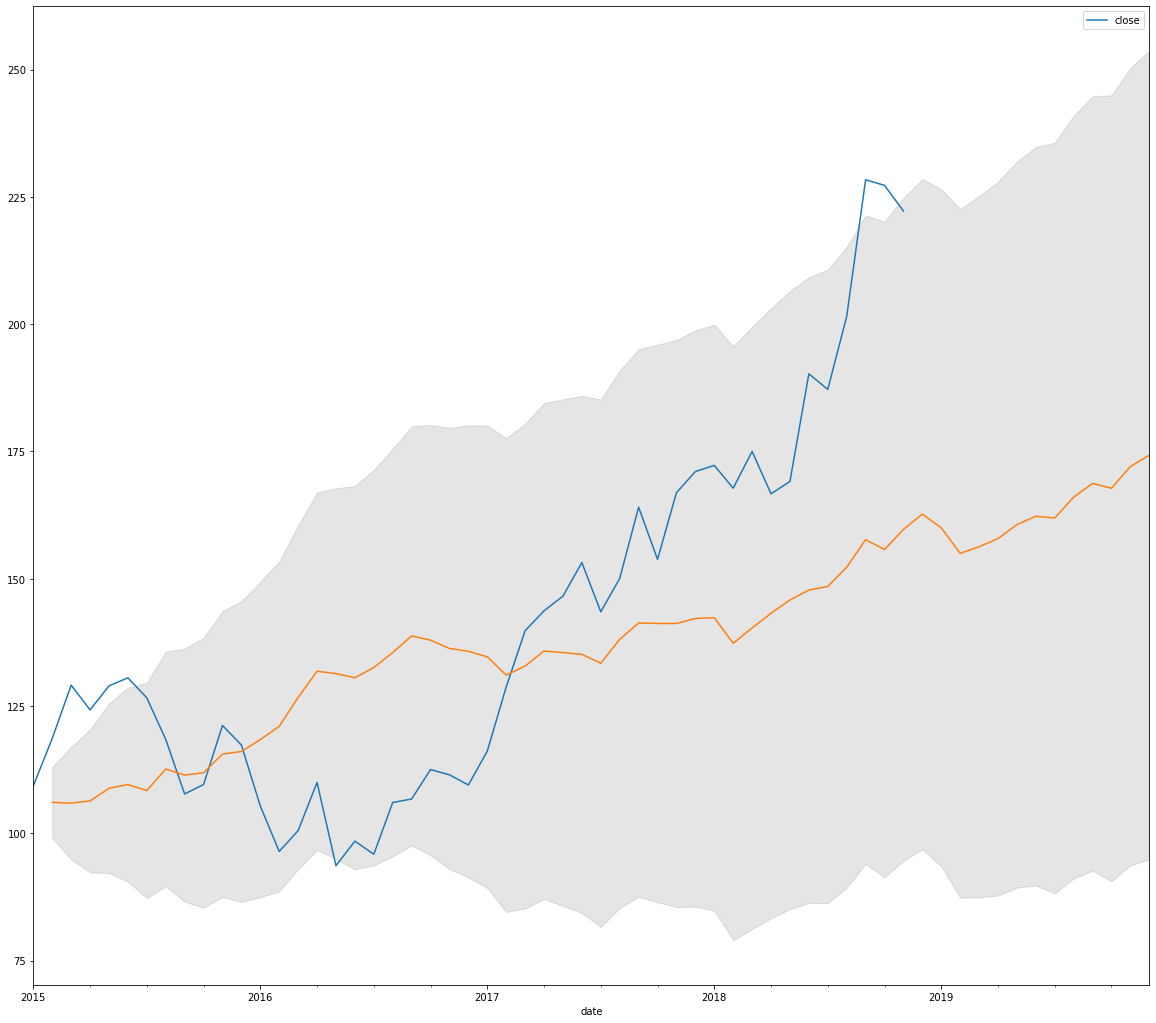

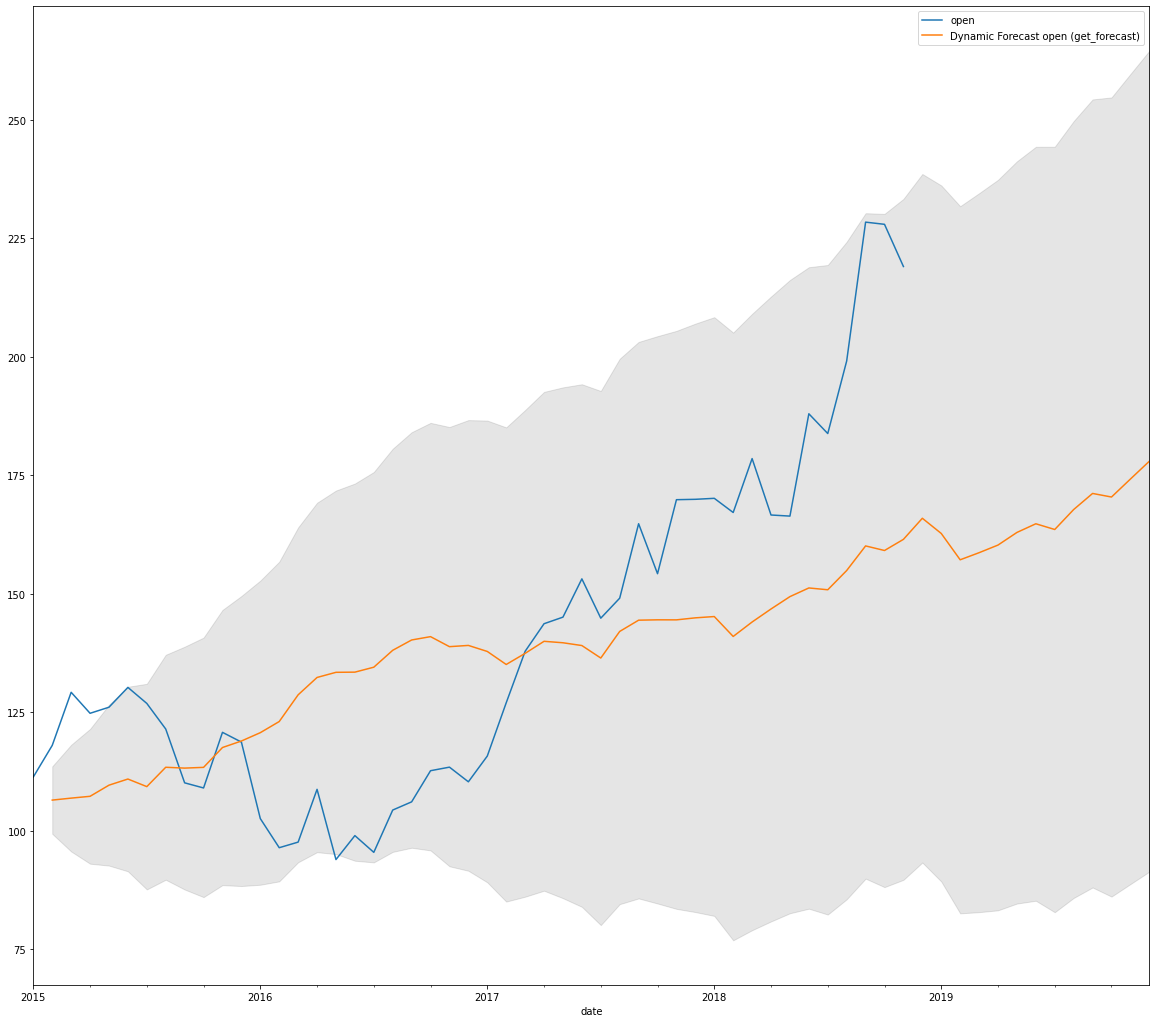

In [178]:
ax = test_data_close.plot(y='close',figsize=(20, 18))
bx = test_data_open.plot(y='open',figsize=(20, 18))
pred_close.predicted_mean.plot(ax=ax, label='Dynamic Forecast close (get_forecast)')
pred_open.predicted_mean.plot(ax=bx, label='Dynamic Forecast open (get_forecast)')
ax.fill_between(pred_close_ci.index, pred_close_ci.iloc[:, 0], pred_close_ci.iloc[:, 1], color='k', alpha=.1)
bx.fill_between(pred_open_ci.index, pred_open_ci.iloc[:, 0], pred_open_ci.iloc[:, 1], color='k', alpha=.1)
# plt.plot(fc_series_close, label='forecast_close')
# plt.plot(fc_series_open, label='forecast_open')
# plt.plot(fc_series_low, label='forecast_low')
# plt.plot(fc_series_high, label='forecast_high')
# plt.xlim(left=start_date, right=end_date)
# plt.ylabel('close')
# plt.fill_between(lower_series_close.index, lower_series_close, upper_series_close, 
#                  color='k', alpha=.15)
# plt.fill_between(lower_series_low.index, lower_series_low, upper_series_low, 
#                  color='k', alpha=.15)
plt.xlabel('date')
plt.legend()
plt.show()

## Generating new Dataframe with forecast

In [185]:
print(len(index), len(fc_series_close))
frame = {'date': index, 'close':fc_series_close, 'low': fc_series_low, 'open': fc_series_open, 'high': fc_series_high}
new_df = pnd.DataFrame(frame)
new_df.set_index('date', inplace=True)
new_df.head()

60 60


,close,low,open,high
date,,,,
2015-01,106.080541,104.744194,106.510306,106.875146
2015-02,105.919069,105.119460,106.927338,107.263718
2015-03,106.358933,106.220533,107.311010,107.403606
2015-04,108.845712,108.481090,109.659911,109.988933
2015-05,109.560082,109.144511,110.953280,111.578412


In [186]:
def aapl_process_data(df, window_size, frame_bound):
    start = frame_bound[0] - window_size
    end = frame_bound[1]
    prices = df.loc[:, 'low'].to_numpy()[start:end]
    signal_features = df.loc[:, ['close', 'open', 'high', 'low']].to_numpy()[start:end]
    return prices, signal_features


class aapl_stocks(StocksEnv):

    def __init__(self, prices, signal_features, **kwargs):
        self._prices = prices
        self._signal_features = signal_features
        super().__init__(**kwargs)

    def _process_data(self):
        return self._prices, self._signal_features


In [187]:
prices, signal_features = aapl_process_data(df=new_df, window_size=30, frame_bound=(30, len(new_df)))
env = aapl_stocks(prices, signal_features, df=new_df, frame_bound=(30, len(new_df)), window_size=6)

In [188]:
env.signal_features

array([[106.08054137, 106.51030609, 106.875146  , 104.74419407],
       [105.91906866, 106.92733796, 107.26371768, 105.11946045],
       [106.35893288, 107.31100953, 107.40360617, 106.22053259],
       [108.84571204, 109.65991113, 109.98893324, 108.48109016],
       [109.56008184, 110.95328008, 111.57841238, 109.14451095],
       [108.39616488, 109.353069  , 110.50451153, 107.88438108],
       [112.62002735, 113.43561013, 114.18226835, 112.23674336],
       [111.42698319, 113.2581776 , 113.81276263, 112.42909883],
       [111.89203541, 113.41488746, 113.93181989, 112.49268751],
       [115.5520718 , 117.59928525, 118.21354265, 115.405524  ],
       [116.06589382, 118.97084555, 119.55133741, 115.91156774],
       [118.41065859, 120.73123021, 121.05196932, 117.58935412],
       [120.99948709, 123.0796081 , 123.57344277, 118.79571873],
       [126.69826785, 128.71466808, 129.02187134, 123.37175234],
       [131.82597698, 132.37603491, 133.41147755, 127.25201252],
       [131.36217935, 133

In [189]:
env.action_space

Discrete(2)

In [219]:
from finta import TA

new_df['SMA'] = TA.SMA(new_df, 12)
new_df['RSI'] = TA.RSI(new_df)
new_df['MACD'] = TA.MACD(new_df)
new_df['EMA'] = TA.EMA(new_df)
new_df.fillna(0, inplace=True)
new_df.head(15)

,close,low,open,high,SMA,RSI,MACD,EMA
date,,,,,,,,
2015-01,106.080541,104.744194,106.510306,106.875146,0.000000,0.000000,0.000000,106.080541
2015-02,105.919069,105.119460,106.927338,107.263718,0.000000,0.000000,-0.003623,105.990834
2015-03,106.358933,106.220533,107.311010,107.403606,0.000000,74.578138,0.009024,106.141694
2015-04,108.845712,108.481090,109.659911,109.988933,0.000000,95.411727,0.104339,107.057690
2015-05,109.560082,109.144511,110.953280,111.578412,0.000000,96.339714,0.182362,107.802095
2015-06,108.396165,107.884381,109.353069,110.504512,0.000000,71.105930,0.176066,107.963121
2015-07,112.620027,112.236743,113.435610,114.182268,0.000000,85.721771,0.360344,109.141660
2015-08,111.426983,112.429099,113.258178,113.812763,0.000000,74.290836,0.421374,109.690866
2015-09,111.892035,112.492688,113.414887,113.931820,0.000000,75.653703,0.480297,110.199347


In [222]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['low','SMA', 'RSI', 'MACD', 'EMA']].to_numpy()[start:end]
    return prices, signal_features

class aapl_custom_env(StocksEnv):
    _process_data = add_signals

env2 = aapl_custom_env(df=new_df, window_size=10, frame_bound=(10,len(new_df)))

In [223]:
env2.signal_features

array([[ 1.04744194e+02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.06080541e+02],
       [ 1.05119460e+02,  0.00000000e+00,  0.00000000e+00,
        -3.62278520e-03,  1.05990834e+02],
       [ 1.06220533e+02,  0.00000000e+00,  7.45781382e+01,
         9.02401579e-03,  1.06141694e+02],
       [ 1.08481090e+02,  0.00000000e+00,  9.54117267e+01,
         1.04339088e-01,  1.07057690e+02],
       [ 1.09144511e+02,  0.00000000e+00,  9.63397144e+01,
         1.82361690e-01,  1.07802095e+02],
       [ 1.07884381e+02,  0.00000000e+00,  7.11059303e+01,
         1.76066291e-01,  1.07963121e+02],
       [ 1.12236743e+02,  0.00000000e+00,  8.57217715e+01,
         3.60344397e-01,  1.09141660e+02],
       [ 1.12429099e+02,  0.00000000e+00,  7.42908359e+01,
         4.21373713e-01,  1.09690866e+02],
       [ 1.12492688e+02,  0.00000000e+00,  7.56537028e+01,
         4.80296920e-01,  1.10199347e+02],
       [ 1.15405524e+02,  0.00000000e+00,  8.32013098e+01,
         7.03633761e-01

In [224]:
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

In [225]:
model = A2C('MlpLstmPolicy', env, verbose=1)
model.learn(total_timesteps=100000)

---------------------------------
| explained_variance | -0.0356  |
| fps                | 29       |
| nupdates           | 1        |
| policy_entropy     | 0.692    |
| total_timesteps    | 5        |
| value_loss         | 0.636    |
---------------------------------
---------------------------------
| explained_variance | -0.0538  |
| fps                | 680      |
| nupdates           | 100      |
| policy_entropy     | 0.693    |
| total_timesteps    | 500      |
| value_loss         | 8.1      |
---------------------------------
---------------------------------
| explained_variance | -0.0132  |
| fps                | 787      |
| nupdates           | 200      |
| policy_entropy     | 0.693    |
| total_timesteps    | 1000     |
| value_loss         | 0.185    |
---------------------------------
---------------------------------
| explained_variance | 0.000653 |
| fps                | 842      |
| nupdates           | 300      |
| policy_entropy     | 0.692    |
| total_timest

---------------------------------
| explained_variance | 0.034    |
| fps                | 818      |
| nupdates           | 3100     |
| policy_entropy     | 0.691    |
| total_timesteps    | 15500    |
| value_loss         | 10.6     |
---------------------------------
---------------------------------
| explained_variance | 0.271    |
| fps                | 818      |
| nupdates           | 3200     |
| policy_entropy     | 0.633    |
| total_timesteps    | 16000    |
| value_loss         | 31.8     |
---------------------------------
---------------------------------
| explained_variance | 0.0562   |
| fps                | 818      |
| nupdates           | 3300     |
| policy_entropy     | 0.69     |
| total_timesteps    | 16500    |
| value_loss         | 4.25     |
---------------------------------
---------------------------------
| explained_variance | -0.024   |
| fps                | 818      |
| nupdates           | 3400     |
| policy_entropy     | 0.693    |
| total_timest

---------------------------------
| explained_variance | -0.00966 |
| fps                | 817      |
| nupdates           | 6200     |
| policy_entropy     | 0.693    |
| total_timesteps    | 31000    |
| value_loss         | 0.383    |
---------------------------------
---------------------------------
| explained_variance | 0.0126   |
| fps                | 817      |
| nupdates           | 6300     |
| policy_entropy     | 0.672    |
| total_timesteps    | 31500    |
| value_loss         | 1.92     |
---------------------------------
---------------------------------
| explained_variance | 0.475    |
| fps                | 817      |
| nupdates           | 6400     |
| policy_entropy     | 0.472    |
| total_timesteps    | 32000    |
| value_loss         | 138      |
---------------------------------
---------------------------------
| explained_variance | -1.1     |
| fps                | 817      |
| nupdates           | 6500     |
| policy_entropy     | 0.681    |
| total_timest

---------------------------------
| explained_variance | 0.000883 |
| fps                | 811      |
| nupdates           | 9300     |
| policy_entropy     | 0.692    |
| total_timesteps    | 46500    |
| value_loss         | 6.02     |
---------------------------------
---------------------------------
| explained_variance | 0.29     |
| fps                | 811      |
| nupdates           | 9400     |
| policy_entropy     | 0.685    |
| total_timesteps    | 47000    |
| value_loss         | 29.8     |
---------------------------------
---------------------------------
| explained_variance | 0.00915  |
| fps                | 811      |
| nupdates           | 9500     |
| policy_entropy     | 0.687    |
| total_timesteps    | 47500    |
| value_loss         | 1.23     |
---------------------------------
---------------------------------
| explained_variance | 0.034    |
| fps                | 811      |
| nupdates           | 9600     |
| policy_entropy     | 0.687    |
| total_timest

---------------------------------
| explained_variance | 0.415    |
| fps                | 807      |
| nupdates           | 12400    |
| policy_entropy     | 0.685    |
| total_timesteps    | 62000    |
| value_loss         | 1.2      |
---------------------------------
---------------------------------
| explained_variance | 0.0223   |
| fps                | 808      |
| nupdates           | 12500    |
| policy_entropy     | 0.617    |
| total_timesteps    | 62500    |
| value_loss         | 15.7     |
---------------------------------
---------------------------------
| explained_variance | -0.00334 |
| fps                | 808      |
| nupdates           | 12600    |
| policy_entropy     | 0.669    |
| total_timesteps    | 63000    |
| value_loss         | 9.96     |
---------------------------------
---------------------------------
| explained_variance | 0.0128   |
| fps                | 808      |
| nupdates           | 12700    |
| policy_entropy     | 0.649    |
| total_timest

---------------------------------
| explained_variance | -0.0797  |
| fps                | 817      |
| nupdates           | 15500    |
| policy_entropy     | 0.652    |
| total_timesteps    | 77500    |
| value_loss         | 41.6     |
---------------------------------
---------------------------------
| explained_variance | -0.0151  |
| fps                | 818      |
| nupdates           | 15600    |
| policy_entropy     | 0.688    |
| total_timesteps    | 78000    |
| value_loss         | 0.957    |
---------------------------------
---------------------------------
| explained_variance | 0.603    |
| fps                | 818      |
| nupdates           | 15700    |
| policy_entropy     | 0.461    |
| total_timesteps    | 78500    |
| value_loss         | 166      |
---------------------------------
---------------------------------
| explained_variance | -6.4     |
| fps                | 818      |
| nupdates           | 15800    |
| policy_entropy     | 0.6      |
| total_timest

---------------------------------
| explained_variance | -0.00381 |
| fps                | 820      |
| nupdates           | 18600    |
| policy_entropy     | 0.675    |
| total_timesteps    | 93000    |
| value_loss         | 2.97     |
---------------------------------
---------------------------------
| explained_variance | 0.435    |
| fps                | 820      |
| nupdates           | 18700    |
| policy_entropy     | 0.678    |
| total_timesteps    | 93500    |
| value_loss         | 15.5     |
---------------------------------
---------------------------------
| explained_variance | 0.00561  |
| fps                | 821      |
| nupdates           | 18800    |
| policy_entropy     | 0.69     |
| total_timesteps    | 94000    |
| value_loss         | 1.14     |
---------------------------------
---------------------------------
| explained_variance | -0.00132 |
| fps                | 821      |
| nupdates           | 18900    |
| policy_entropy     | 0.693    |
| total_timest

In [226]:
env = aapl_custom_env(df=new_df, window_size=10, frame_bound=(10,len(new_df)))
obs = env.reset()

# obs_first = obs[np.newaxis, ...] 
# action, _states = model.predict(obs_first)
# obs, rewards, done, info = env.step(action)
# print(obs, done)
# obs_second = obs[np.newaxis, ...]
# action, _states = model.predict(obs_second)
# obs, rewards, done, info = env.step(action)
# print(obs)
# print('info', info)
while True:
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print('info', info)
        break

info {'total_reward': 47.62171694599368, 'total_profit': 1.1792378049472858, 'position': 1}


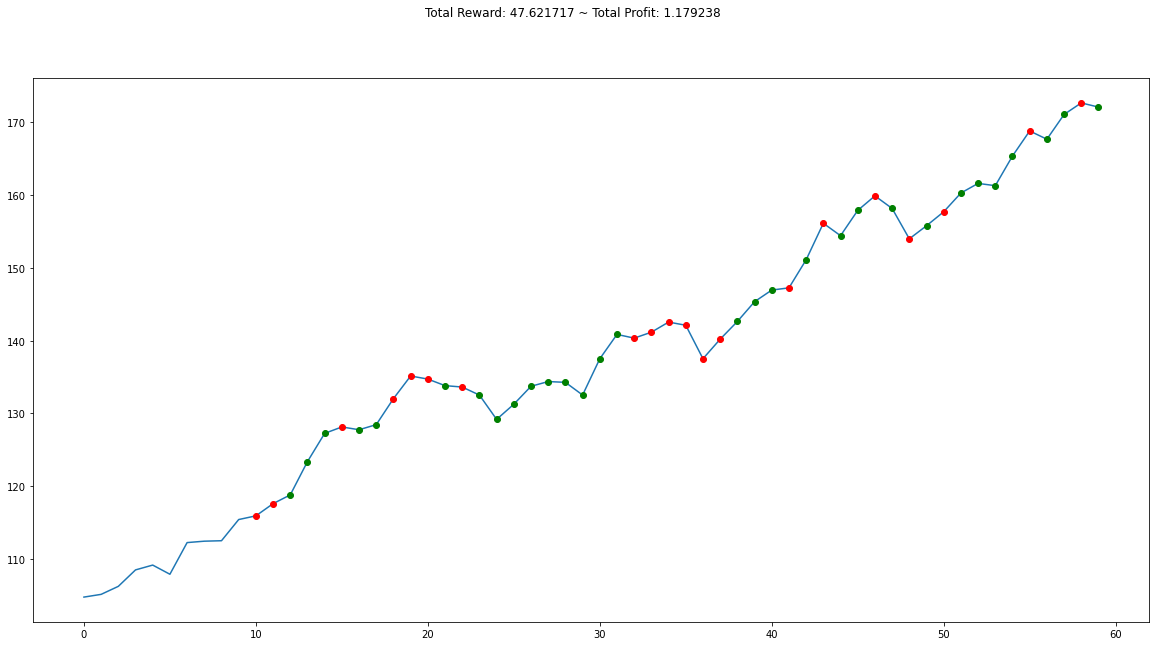

In [227]:
plt.figure(figsize=(20,10))
plt.cla()
env.render_all()
plt.show()